## 1. Import Library
___

In [1]:
import os
import sys
import pickle
import random
import gc
import ctypes
import copy

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from colorama import Fore

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.functional as F

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.GREEN}=> Installed Necessary Library')

=> Installed Necessary Library


### Configuration

In [2]:
class CFG:
    debug = False
    output_dir = 'runs/detect'
    seed = 42
    train_ds = 'gastroscopy_train'

    img_size = [1024,1024]
    input_format = 'BGR'
    imgdir = '/kaggle/input/gastroscopy-1024x1024-resized-png'
    mapper_type = 'albu' # 'detectron2'

    split_mode = 'valid20'
    max_iter = 5_000 # default 40_000
    ims_per_batch = 8
    num_workers = 4 
    
    lr_scheduler_name = 'WarmupCosineLR' # WarmupMultiStepLR
    base_lr = 0.0025 # default: 1e-3
    base_lr_end = 0 # default: 0
    weight_decay = 1e-5 # default 1e-4
    warmup_factor = base_lr*0.1 # default: 1e-3
    warmup_iters = max_iter // 20 # default: 1_000
    eval_period = max_iter * 10
    amp = True # Auto Mixed Precision
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.output_dir, exist_ok=True)

### Reproducibility

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark= False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_Memory

In [4]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
    
clean_memory()

### Install Detectron Library

In [5]:
print(f'=> {Fore.GREEN}Installing Detectron2 Library...' )
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

## Or, to install it from a local clone:
# !git clone https://github.com/facebookresearch/detectron2.git
# !python -m pip install -e detectron2

=> Installing Detectron2 Library...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.7 MB/s eta 0:00:00


## 2. Build Dataset_Dicts
___

- **궤양**: `ulcer(label: 0)`

- **용종**: `polyp(label: 1)`

- **암**: `cancer(label: 2)`

In [6]:
meta_data = pd.read_csv('/kaggle/input/gastroscopy-meta/gastroscopy_data2.csv')
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head()

Shape of DataFrame:  (2915, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170,ulcer
1,1_1_00011.png,2048,2048,gastroscopy,0,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723,ulcer
2,1_1_00014.png,2048,2048,gastroscopy,0,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915,ulcer
3,1_1_00017.png,2048,2048,gastroscopy,0,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489,ulcer
4,1_1_00018.png,2048,2048,gastroscopy,0,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085,ulcer


In [7]:
thing_classes = [
    'Ulcer',
    'Polyp',
    'Cancer',
]

category_id_to_name = {index: class_name for index,class_name in enumerate(thing_classes) }

meta_data['lesion'] = meta_data['lesion_label'].map(category_id_to_name)

In [8]:
train_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-1024x1024-resized-png/train/*.png')] 
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/gastroscopy-1024x1024-resized-png/test/*.png')] 

train_df = meta_data[meta_data['image_id'].isin(train_id)].reset_index(drop=True)
test_df = meta_data[meta_data['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1597
=> Number of Unique Image_id in Test:  400


### Dectectron2 Library Dataset Format

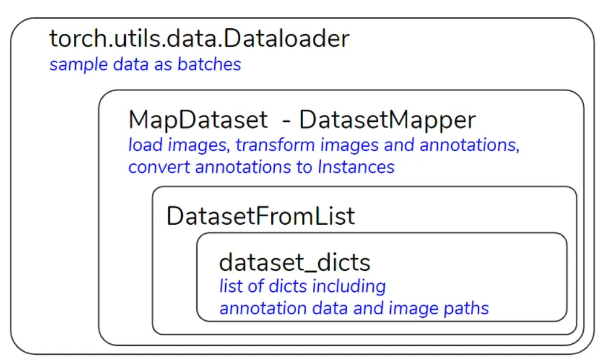


<div style="border-radius:10px; border:#000000 solid; padding: 15px; font-size:100%;">


📌 **`dataset_dicts`**: Metadata of Image, in Detectron2 Dataset Format

To define custom datasets, we need to create list of dict(`dataset_dicts`) where each dict contains following:

- `file_name`: file name of the image
- `image_id`: id of the image, index is used here.
- `height`: height of the image
- `width`: width of the image
- `annotation`: This the ground truth annotation data for object detection, which contains following:
  - `bbox`: bounding box pixel location with shape(n_boxes, 4)
  - `bbox_mode`: BoxMode.XYXY_ABS meaning that absolute value of (xmin, ymin, xmax, ymax)
  - `category_id`: class label id for each bounding box, with shape(n_boxes,)


### Define Dataset_dicts

In [9]:
from detectron2.structures import BoxMode

def get_gastroscopy_dicts(
    imgdir: str, 
    df,
    mode: str = 'train',
    use_cache: bool = True, 
    debug: bool = True,
    target_indices: list = None
): 
    debug_str = f"_debug{int(debug)}"
    cache_path = f'/kaggle/working/dataset_dicts_cache_{mode}{debug_str}.pkl'

    if not use_cache or not os.path.exists(cache_path):
       print(f'{Fore.BLUE}#'* 25)
       print(f'### Creating {mode} Data...')
       print('#' * 25)

       meta_df = pd.read_csv(f'/kaggle/input/gastroscopy-1024x1024-resized-png/{mode}_meta.csv')
        
       if debug:
           meta_df = meta_df[:500]

       image_id = meta_df.loc[0,'image_id']
       image_path = os.path.join(imgdir,mode, image_id)
       image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
       resized_height, resized_width, channel = image.shape
       print(f'=> Height of Image: {resized_height}')
       print(f'=> Width of Image: {resized_width}')

       dataset_dicts = []
       for _, (image_id, height, width) in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Build Dataset Dict'):
           record = {}
           record['file_name'] = os.path.join(imgdir,'train',image_id)
           record['image_id'] = image_id
           record['height'] = resized_height
           record['width'] = resized_width

           if mode != 'test':
              objs = []
              for _, row in df[df.image_id == image_id].iterrows():
                  class_id = row['lesion_label']

                  h_ratio = resized_height / height
                  w_ratio = resized_width / width

                  bbox_resized = [
                      row['x_min'] * w_ratio,
                      row['y_min'] * h_ratio,
                      row['x_max'] * w_ratio,
                      row['y_max'] * h_ratio,
                  ]

                  obj = {
                     'bbox': bbox_resized,
                     'bbox_mode': BoxMode.XYXY_ABS,
                     'category_id': class_id,
                  }
                  objs.append(obj)
              record['annotations'] = objs
              dataset_dicts.append(record)
           else: 
              dataset_dicts.append(record)
       with open(cache_path, mode='wb') as f:
           pickle.dump(dataset_dicts, f)
    with open(cache_path, mode='rb') as f:
        dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

### Load Dataset_dicts

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog

if CFG.split_mode == 'valid20':
    n_dataset = len(
        get_gastroscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug)
        )
    
    n_train = int(n_dataset * 0.8)
    n_valid = n_dataset - n_train
    rs = np.random.RandomState(CFG.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]

    print(f'n_train: {len(train_inds)} n_valid: {len(valid_inds)}')

    DatasetCatalog.register(
        'gastroscopy_train',
        lambda: get_gastroscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug, target_indices = train_inds
        )
    )
    MetadataCatalog.get('gastroscopy_train').set(thing_classes = thing_classes)

    DatasetCatalog.register(
        'gastroscopy_valid',
        lambda: get_gastroscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug, target_indices = valid_inds
        )
    )

    MetadataCatalog.get('gastroscopy_valid').set(thing_classes = thing_classes)

#########################
### Creating train Data...
#########################
=> Height of Image: 1024
=> Width of Image: 1024


Build Dataset Dict: 100%|██████████| 1597/1597 [00:01<00:00, 1315.69it/s]

n_train: 1277 n_valid: 320


In [11]:
dataset_dicts = get_gastroscopy_dicts(CFG.imgdir, train_df, mode='train', debug=CFG.debug)

clean_memory();

## 3. Build DatasetMapper
___

**`DatasetMapper`**:

=> **Load images** 

=> **transform images and annotations**

=> **convert annotations to Instances**

**`Dectecron2 Image Augmentation System`**

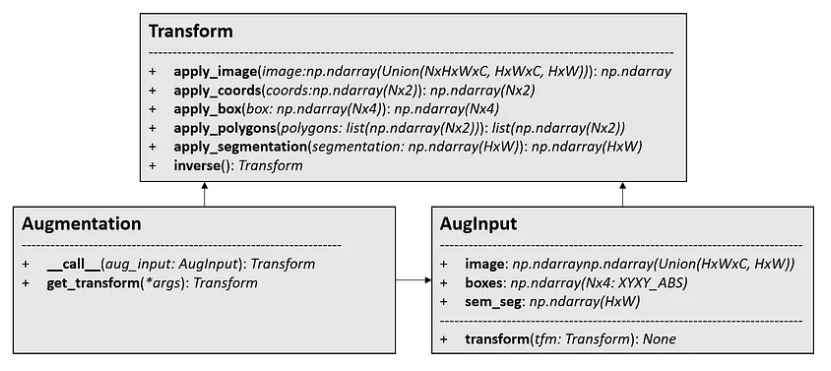


### 📌 Albumentations DatasetMapper

But this notebook, I'm gonna use `Albumentations` not use Detectron2 Image Augmentation System

In [12]:
def get_train_transform():
    return A.Compose(
               [
                A.HorizontalFlip(p=0.5),

                ## CLAHE
                A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0),

               
                ### Channel Transform
                A.OneOf([
                    A.ChannelShuffle(p=1.0),
                    A.ChannelDropout(p=1.0),
                    A.ToGray(p=1.0),
                    A.RGBShift(r_shift_limit=[-5,5], g_shift_limit=[-5,5], b_shift_limit=[-5,5], p=1.0)],
                    p=0.5),

                ### Dropout Transform   
                A.OneOf([
                    A.XYMasking(
                        num_masks_x=[1,1],
                        num_masks_y=[1,1],
                        mask_x_length = [int(CFG.img_size[1] * 0.05),int(CFG.img_size[1] * 0.1)],
                        mask_y_length = [int(CFG.img_size[0] * 0.05),int(CFG.img_size[0] * 0.1)],
                        p=1.0),
                    A.CoarseDropout(
                        num_holes_range=[2,4],
                        hole_height_range=[int(CFG.img_size[0] * 0.05),int(CFG.img_size[0] * 0.1)],
                        hole_width_range=[int(CFG.img_size[1] * 0.05),int(CFG.img_size[1] * 0.1)],p=1.0),
                    A.BBoxSafeRandomCrop(
                        height=int(CFG.img_size[0] * 0.8),  # 높이 계산
                         width=int(CFG.img_size[1] * 0.8), p=1.0),],
                    p=0.25),

                ## Noisy Transform
                A.OneOf([
                    A.RandomGravel(number_of_patches=1, p=1.0),
                    A.RandomSnow(brightness_coeff=1.1, p=1.0),
                ],
                    p=0.25
                       ), 
                
                A.Resize(*CFG.img_size, p=1.0),
                ],
        
                bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids'],)
    ) 
        
def get_valid_transform():
    return A.Compose(
                [A.Resize(*CFG.img_size, p=1.0),],
        
                bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids'])
    )

In [13]:
import albumentations as A
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

class AlbumentationsMapper:
    def __init__(self, is_train: bool=True, mixup_prob: float=0.1, mosaic_prob: float=0.25):
        self.is_train = is_train
        self.mixup_prob = mixup_prob
        self.mosaic_prob = mosaic_prob
        
        if self.is_train:
            self.transform = get_train_transform()
        else:
            self.transform = get_valid_transform()
            

        mode='training' if self.is_train else 'inference'
        print(f'{Fore.GREEN}[AlbumentationsMapper]{Fore.BLACK} Augmentations used in {mode}: {self.transform}')

    def datadict_sampler(self, ds_name=CFG.train_ds, n=3):
        ds = DatasetCatalog.get(ds_name)

        indices = np.random.randint(0, len(ds) - 1, n)
        return [copy.deepcopy(ds[idx]) for idx in indices]

    def __mixup_transform(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)
        mu_dict = self.datadict_sampler(n=1)[0]

        image = utils.read_image(dataset_dict['file_name'],format=CFG.input_format)
        mu_image = utils.read_image(mu_dict['file_name'], format=CFG.input_format)

        lam = np.random.beta(2.0, 2.0)
        image = (lam * image + (1 - lam) * mu_image).astype(np.uint8)
        
        transform = A.Compose([A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0)])
        image = transform(image=image)['image']
        dataset_dict['image'] = image
        dataset_dict['annotations'] += mu_dict['annotations']

        transform = A.Compose([
            A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0),  A.Resize(*CFG.img_size, p=1.0),],
            bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids']))

        bboxes = np.array([obj['bbox'] for obj in dataset_dict['annotations']], dtype=np.float32)
        annotation_id = np.arange(len(dataset_dict['annotations']))

        transformed = transform(image=dataset_dict['image'], bboxes=bboxes, category_ids=annotation_id)
        dataset_dict['image'] = transformed['image']
        
        for i in transformed['category_ids']:
            dataset_dict['annotations'][i]['bbox'] = transformed['bboxes'][i] 
            
        return dataset_dict

    def __mosaic_transform(self, dataset_dict):
        dataset_dict= copy.deepcopy(dataset_dict)
        image = utils.read_image(dataset_dict['file_name'],format=CFG.input_format)
        im_h, im_w = image.shape[:2]
        resized_w = random.randint(int(CFG.img_size[0]*0.75), int(CFG.img_size[0]*1.25))
        resized_h = random.randint(int(CFG.img_size[1]*0.75), int(CFG.img_size[1]*1.25))
        image = cv2.resize(image, (resized_w, resized_h))
        boxes = np.array([anno['bbox'] for anno in dataset_dict['annotations']]) 
        boxes[:,[0,2]] *= resized_w / im_w
        boxes[:,[1,3]] *= resized_h / im_h
        
        mo_items = self.datadict_sampler(n=3)
        mo_images = []
        mo_boxes = []
        
        resize_list = [
            [(im_w*2-resized_w),resized_h], [resized_w,(im_h*2-resized_h)], [(im_w*2-resized_w),(im_h*2-resized_h)],
        ]
        
        for i, mo_dict in enumerate(mo_items):
            mo_image = utils.read_image(mo_dict['file_name'],format=CFG.input_format)
            mo_h, mo_w = mo_image.shape[:2]
            mo_image = cv2.resize(mo_image, (resize_list[i][0], resize_list[i][1]))
            mo_images.append(mo_image)
            mo_bbox = np.array([
                 anno['bbox'] for anno in mo_dict['annotations']
            ])
            mo_bbox[:,[0,2]] *= resize_list[i][0] / mo_w
            mo_bbox[:,[1,3]] *= resize_list[i][1] / mo_h
            mo_boxes.append(mo_bbox)
             
        
            dataset_dict['annotations'] += mo_dict['annotations']
        
        images = [image] + mo_images
        boxes = [boxes] + mo_boxes

        
        heights = [i.shape[0] for i in images] 
        widths =  [i.shape[1] for i in images]

        ch = max(heights[0], heights[1])
        cw = max(widths[0], widths[2]) 
        h = (max(heights[0], heights[1]) + 
             max(heights[2], heights[3]))
        w = (max(widths[0], widths[2]) +
             max(widths[1], widths[3]))
        
        # pad or start coordinates 
        y0, x0 = ch - heights[0], cw - widths[0] # Height: 0,  Width: 0 
        y1, x1 = ch - heights[1], cw # Height: 0, Width: 256 
        y2, x2 = ch, cw - widths[2] # Height: 256, Width: 0
        y3, x3 = ch, cw # Height: 256, Width: 256
        x_pads = [x0, x1, x2, x3]
        y_pads = [y0, y1, y2, y3]

        output = np.zeros((h,w,3)).astype(np.uint8)
        for i, img in enumerate(images):
            output[y_pads[i]: y_pads[i] + heights[i],
                   x_pads[i]: x_pads[i] + widths[i],
                   :] = img
        transform = A.Compose([A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0)])
        output = transform(image=output)['image']
        dataset_dict['image'] = output

        for i, bbox in enumerate(boxes):
            bbox += np.array([x_pads[i], y_pads[i], x_pads[i], y_pads[i]])
            
        boxes = np.vstack(boxes)

        for i, box in enumerate(boxes):
            dataset_dict['annotations'][i]['bbox'] = box

        transform = A.Compose([
            A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0),  A.Resize(*CFG.img_size, p=1.0),],
                    bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids']))

        bboxes = np.array([obj['bbox'] for obj in dataset_dict['annotations']], dtype=np.float32)
        annotation_id = np.arange(len(dataset_dict['annotations']))

        transformed = transform(image=dataset_dict['image'], bboxes=bboxes, category_ids=annotation_id)
        dataset_dict['image'] = transformed['image']
        
        for i in transformed['category_ids']:
            dataset_dict['annotations'][i]['bbox'] = transformed['bboxes'][i] 
        
        return dataset_dict
        
    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)

        if self.is_train:
            if np.random.rand() <= self.mosaic_prob:
               dataset_dict = self.__mosaic_transform(dataset_dict)

               image = dataset_dict['image']

               image_shape = dataset_dict['image'].shape[:2] # height, width
               dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

               instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
               dataset_dict['instances'] = utils.filter_empty_instances(instances)

               dataset_dict.pop('annotations', None)

               return dataset_dict
            elif np.random.rand() <= self.mixup_prob:
               dataset_dict = self.__mixup_transform(dataset_dict)
    

               image = dataset_dict['image']

               image_shape = dataset_dict['image'].shape[:2] # height, width
               dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

               instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
               dataset_dict['instances'] = utils.filter_empty_instances(instances)

               dataset_dict.pop('annotations', None)

               return dataset_dict

        
        image = utils.read_image(dataset_dict['file_name'], format=CFG.input_format)

        ### Bounding Box
        bboxes = np.array([obj['bbox'] for obj in dataset_dict['annotations']], dtype=np.float32)
        annotation_id = np.arange(len(dataset_dict['annotations']))

        ### Applying Augmentation
        transformed = self.transform(image=image, bboxes=bboxes, category_ids=annotation_id)
        dataset_dict['image'] = transformed['image']
        
        for i in transformed['category_ids']:
            dataset_dict['annotations'][i]['bbox'] = transformed['bboxes'][i] 
        

        image_shape = dataset_dict['image'].shape[:2] # height, width
        dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

        instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
        dataset_dict['instances'] = utils.filter_empty_instances(instances)

        ## Remove annotations for convert to instances
        dataset_dict.pop('annotations', None)

        return dataset_dict

## 4. Build Detectron2 Custom Trainer
___

In [14]:
import detectron2
from detectron2 import model_zoo # model library
from detectron2.config import get_cfg # Get a copy of the default config

from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data import build_detection_train_loader, build_detection_test_loader

from detectron2.engine import DefaultPredictor, DefaultTrainer

from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.solver.build import get_default_optimizer_params, maybe_add_gradient_clipping

from detectron2.evaluation import COCOEvaluator
from detectron2.evaluation import PascalVOCDetectionEvaluator

from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode

setup_logger() # Initialize the detectron2 logger and set its verbosity level to 'debug'

class MyTrainer(DefaultTrainer):

    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(is_train = True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(is_train = False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, 'inference')
        
        return COCOEvaluator(
            dataset_name = dataset_name, # name of the dataset to be evaluated
            tasks = ("bbox",), 
            distributed = False, # only evalute the results in the current process
            output_dir=output_folder)

            ## Results predicted on the dataset
            ### instances_predictions.pth
            ### coco_instances_results.json: json file in COCO's result format

## 5. Visualization Gastroscopy Augmentation
___

In [15]:
gastroscopy_metadata = MetadataCatalog.get('gastroscopy_train')
print(gastroscopy_metadata)

Metadata(name='gastroscopy_train', thing_classes=['Ulcer', 'Polyp', 'Cancer'])


[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(p=0.5),
  CLAHE(p=1.0, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
  OneOf([
    ChannelShuffle(p=1.0),
    ChannelDropout(p=1.0, channel_drop_range=(1, 1), fill_value=0.0),
    ToGray(p=1.0, num_output_channels=3, method='weighted_average'),
    RGBShift(p=1.0, r_shift_limit=(-5, 5), g_shift_limit=(-5, 5), b_shift_limit=(-5, 5)),
  ], p=0.5),
  OneOf([
    XYMasking(p=1.0, num_masks_x=(1, 1), num_masks_y=(1, 1), mask_x_length=(51, 102), mask_y_length=(51, 102), fill_value=0.0, mask_fill_value=0.0),
    CoarseDropout(p=1.0, fill_value=0.0, mask_fill_value=None, num_holes_range=(2, 4), hole_height_range=(51, 102), hole_width_range=(51, 102)),
    BBoxSafeRandomCrop(p=1.0, erosion_rate=0.0),
  ], p=0.25),
  OneOf([
    RandomGravel(p=1.0, gravel_roi=(0.1, 0.4, 0.9, 0.9), number_of_patches=1),
    RandomSnow(p=1.0, snow_point_range=(0.1, 0.3), brightness_coeff=1.1),
  ], p=0.25),
  Resize(p=1.0, height=10

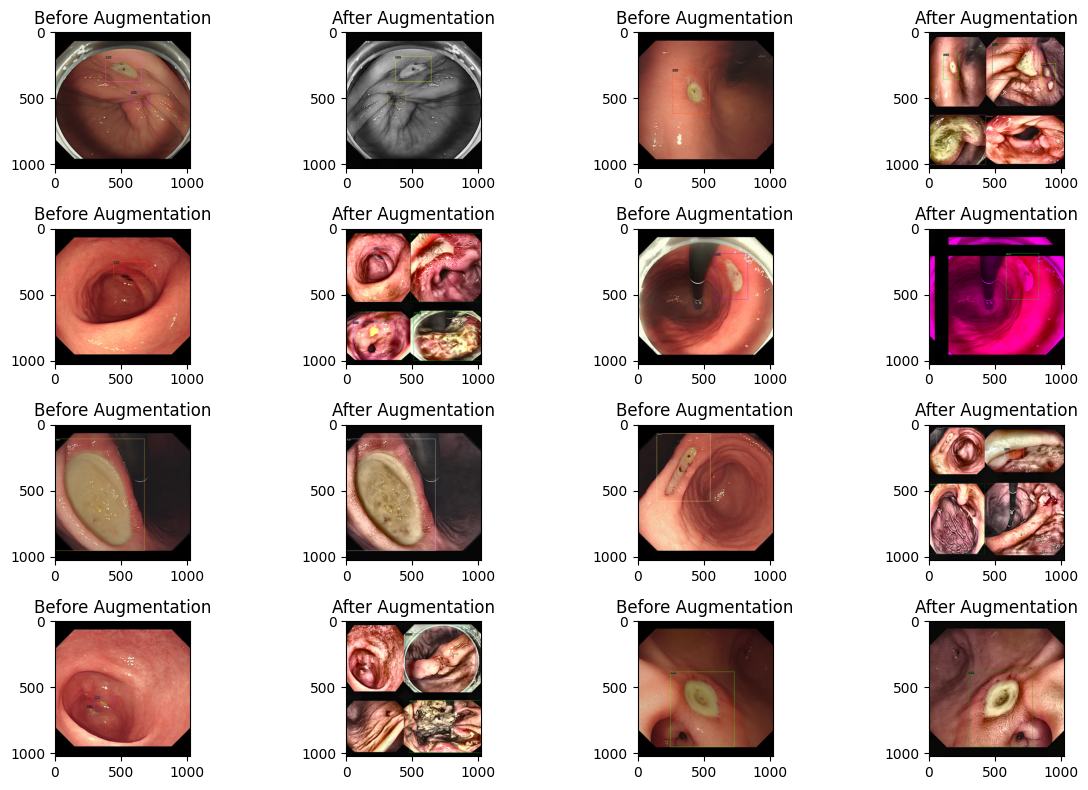

In [16]:
mapper = AlbumentationsMapper(is_train=True)

plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(4,4,2*i+1)
    plt.title('Before Augmentation')
    d = dataset_dicts[i]
    img = Image.open(d['file_name']).convert('RGB')
    img = np.array(img)
    visualizer = Visualizer(img, metadata=gastroscopy_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    #plt.axis('off')
    
    plt.subplot(4,4, 2*i+2)
    plt.title('After Augmentation')
    mapped_d = mapper(d)
    img_arr = mapped_d['image'].cpu().permute(1,2,0).numpy()
    # img_arr[:,:,::-1] # BGR -> RGB
    visualizer = Visualizer(img_arr[:,:,::-1], metadata=gastroscopy_metadata, scale=1.0)
    target_fields = mapped_d['instances'].get_fields()
    labels = [gastroscopy_metadata.thing_classes[i] for i in target_fields['gt_classes']]

    out = visualizer.overlay_instances(
        labels = labels,
        boxes = target_fields.get('gt_boxes',None),
        masks = target_fields.get('gt_masks',None),
        keypoints = target_fields.get('gt_keypoints', None)
    )
     
    plt.imshow(out.get_image())
    # plt.axis('off')

    del out, visualizer, labels
    
plt.tight_layout()
plt.show()

del mapper; clean_memory()

## 6. Setting Detectron2 Model Config
___

📌 [**Detectron2's Default CfgNode**](https://github.com/facebookresearch/detectron2/blob/main/detectron2/config/defaults.pyall)

In [17]:
from detectron2.config import CfgNode as CN

cfg = get_cfg()
cfg.OUTPUT_DIR = CFG.output_dir

## R_50_FPN_1x, R_50_FPN_3x, R_101_FPN_3x, X_101_32x8d_FPN_3x 

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.INPUT.F0RMAT = CFG.input_format
cfg.DATASETS.TRAIN = ('gastroscopy_train',)
cfg.DATASETS.TEST = ('gastroscopy_valid',)
cfg.TEST.EVAL_PREIOD = CFG.eval_period
cfg.DATALOADER.NUM_WORKERS = CFG.num_workers

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.BACKBONE.FREEZE_AT = 2

cfg.MODEL.FPN.IN_FEATURES = ['res2','res3','res4','res5']
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.MODEL.FPN.FUSE_TYPE = 'sum'
cfg.MODEL.FPN.NORM = ""

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 32, 64, 128, 256, 386, 512, 800]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0, 2.5]]
cfg.MODEL.ANCHOR_GENERATOR.OFFSET = 0.5

## RPN Options
cfg.MODEL.RPN.IN_FEATURES = ["p2", "p2", "p2", "p3", "p4", "p5", "p5", "p6", "p6"]
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.7]
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 386 # 256 -> 386
cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE = 'ciou' # smooth_l1 -> ciou
cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.RPN.POSITIVE_FRACTION = 0.5
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 2000 # Per FPN Levels
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1000 # Per FPN Levels
cfg.MODEL.RPN.POST_NMS_TOPK = 1000 # Total
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 500

## ROI Options
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.IN_FEATURES = ['p2','p3','p4','p5']
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.45] # 0.5 -> 0.45
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
cfg.MODEL.ROI_BOX_HEAD.POOLR_TYPE = 'ROIAlignV2'
cfg.MODEL.ROI_BOX_HEAD.BBOX_RGE_LOSS_TYPE = 'ciou' # smooth_l1 -> ciou
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT = 1.0
cfg.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION = 14

## Solver(Optimizer and Scheduler Builders)
cfg.SOLVER.IMS_PER_BATCH = CFG.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = CFG.lr_scheduler_name
cfg.SOLVER.BASE_LR = CFG.base_lr
cfg.SOLVER.AMP.ENABLED = CFG.amp
cfg.SOLVER.WEIGHT_DECAY = CFG.weight_decay
cfg.SOLVER.MAX_ITER = CFG.max_iter
cfg.SOLVER.WARMUP_ITERS = CFG.warmup_iters
cfg.SOLVER.WARMUP_FACTOR = CFG.warmup_factor
cfg.SOLVER.CHECKPOINT_PREIOD = CFG.eval_period

## Post Processing
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.00 # No More Penalty for adding lower box
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
cfg.TEST.DETECTIONS_PER_IMAGE = 100 # 200, 300, 400, 500

print(f"{Fore.BLUE}=> Completed Setting Detectron2's Model Config !")

=> Completed Setting Detectron2's Model Config !


### Save Config Yaml

In [18]:
import yaml

with open(os.path.join(CFG.output_dir, 'config.yaml'), mode='w') as f:
    yaml.dump(cfg.dump(), f, default_flow_style=False, sort_keys=False, indent=4)

print(f'{Fore.BLUE}=> Yaml File Completely Saved !')

=> Yaml File Completely Saved !


In [19]:
SHOW = False

if SHOW:
   with open(os.path.join(CFG.output_dir, 'config.yaml'), mode='r') as f:
       print(yaml.safe_load(f))

## 7. Training
___

In [20]:
trainer = MyTrainer(cfg)

trainer.resume_or_load(resume=False) # load last checkpoint or MODEL.WEIGHTS

trainer.train()

torch.cuda.empty_cache()
clean_memory(); del trainer

[02/03 02:54:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:00, 185MB/s]                           


[02/03 02:54:46 d2.engine.train_loop]: Starting training from iteration 0
[02/03 02:55:34 d2.utils.events]:  eta: 3:00:32  iter: 19  total_loss: 2.302  loss_cls: 1.266  loss_box_reg: 0.05698  loss_rpn_cls: 0.6829  loss_rpn_loc: 0.2852    time: 2.1842  last_time: 2.1967  data_time: 0.1024  last_data_time: 0.0534   lr: 0.00018941  max_mem: 10294M
[02/03 02:56:30 d2.utils.events]:  eta: 3:02:34  iter: 39  total_loss: 1.785  loss_cls: 0.4832  loss_box_reg: 0.3791  loss_rpn_cls: 0.6204  loss_rpn_loc: 0.2125    time: 2.2135  last_time: 2.2511  data_time: 0.0517  last_data_time: 0.0537   lr: 0.00038813  max_mem: 10294M
[02/03 02:57:16 d2.utils.events]:  eta: 3:03:43  iter: 59  total_loss: 1.682  loss_cls: 0.4411  loss_box_reg: 0.5165  loss_rpn_cls: 0.5629  loss_rpn_loc: 0.1976    time: 2.2271  last_time: 2.2318  data_time: 0.0482  last_data_time: 0.0474   lr: 0.00058685  max_mem: 10294M
[02/03 02:58:01 d2.utils.events]:  eta: 3:03:57  iter: 79  total_loss: 1.566  loss_cls: 0.3751  loss_box_re

### Visualize Train Metrics

In [21]:
metrics = pd.read_json(os.path.join(CFG.output_dir, 'metrics.json'), orient='records', lines=True)
metrics = metrics.sort_values(by=['iteration'])

print('Shape of Metrics: ',metrics.shape)
metrics.head()

Shape of Metrics:  (251, 27)


,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,...,total_loss,bbox/AP,bbox/AP-Cancer,bbox/AP-Polyp,bbox/AP-Ulcer,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs
0,0.051360,10832.360235,0.854980,0.52204,0.18254,19,0.056976,1.266047,0.682884,0.285242,...,2.301937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.051987,10954.097184,0.916382,1.00000,0.00000,39,0.379060,0.483235,0.620368,0.212547,...,1.785307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.047087,11023.972724,0.890381,1.00000,0.00000,59,0.516533,0.441083,0.562910,0.197553,...,1.682057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.052674,11037.422685,0.892700,1.00000,0.00000,79,0.501548,0.375082,0.509581,0.184587,...,1.565876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.051111,11021.616080,0.869263,1.00000,0.00000,99,0.606438,0.416341,0.434072,0.178801,...,1.650150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- #### Scheduler Graph

Scheduler Type is : WarmupCosineLR
Base Learning Rate is : 0.0025
Iteration is:  5000
Warmup Iteration is:  250


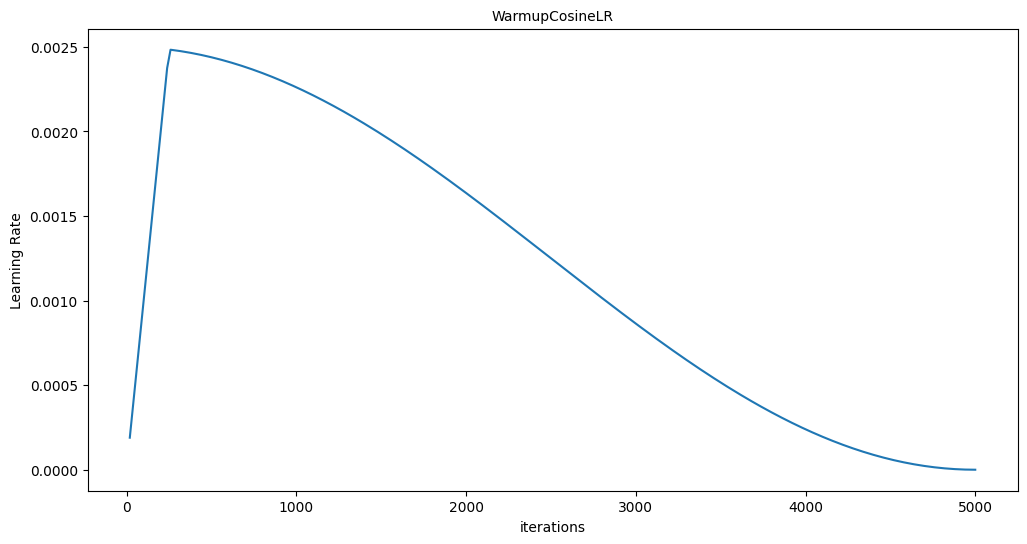

In [22]:
print('Scheduler Type is :', CFG.lr_scheduler_name)
print('Base Learning Rate is :', CFG.base_lr)
print('Iteration is: ', CFG.max_iter)
print('Warmup Iteration is: ', CFG.warmup_iters)

plt.style.use('default')
plt.figure(figsize=(12,6))
plt.title(CFG.lr_scheduler_name, size=10)

tmp = metrics[~metrics['lr'].isna()]

plt.plot(tmp['iteration'], tmp['lr'])
plt.xlabel('iterations')
plt.ylabel('Learning Rate')

plt.show()

- #### Foreground & Background Fraction in RPN & ROI

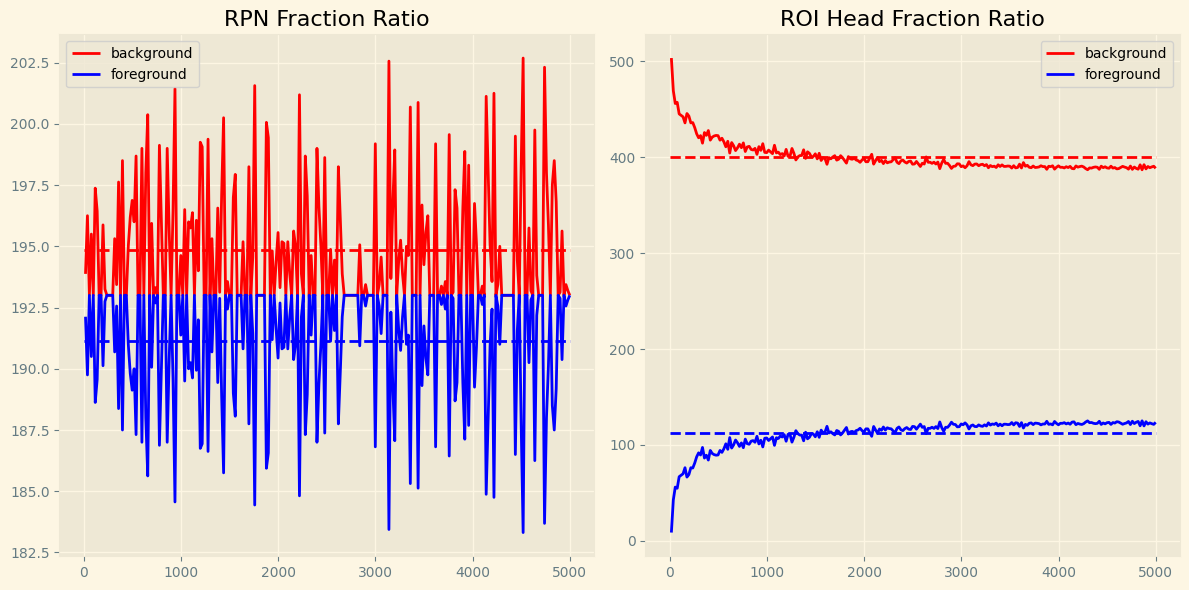

In [23]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('RPN Fraction Ratio')
tmp = metrics[~metrics['rpn/num_neg_anchors'].isna()]
tmp = tmp[~tmp['rpn/num_pos_anchors'].isna()]
plt.plot(tmp['iteration'], tmp['rpn/num_neg_anchors'], color='red', label='background')
plt.plot([0,tmp['iteration'].max()], [tmp['rpn/num_neg_anchors'].mean(), tmp['rpn/num_neg_anchors'].mean()], '--', color='red')
plt.plot(tmp['iteration'], tmp['rpn/num_pos_anchors'], color='blue', label='foreground')
plt.plot([0,tmp['iteration'].max()], [tmp['rpn/num_pos_anchors'].mean(),tmp['rpn/num_pos_anchors'].mean()], '--', color='blue')

plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title('ROI Head Fraction Ratio')
tmp = metrics[~metrics['roi_head/num_bg_samples'].isna()]
tmp = tmp[~tmp['roi_head/num_fg_samples'].isna()]
plt.plot(tmp['iteration'], tmp['roi_head/num_bg_samples'], color='red', label='background')
plt.plot([0,tmp['iteration'].max()], [tmp['roi_head/num_bg_samples'].mean(), tmp['roi_head/num_bg_samples'].mean()], '--', color='red')
plt.plot(tmp['iteration'], tmp['roi_head/num_fg_samples'], color='blue', label='foreground')
plt.plot([0,tmp['iteration'].max()], [tmp['roi_head/num_fg_samples'].mean(),tmp['roi_head/num_fg_samples'].mean()], '--', color='blue')

plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

- #### Loss: rpn_loc, rpn_cls, box_reg, box_cls

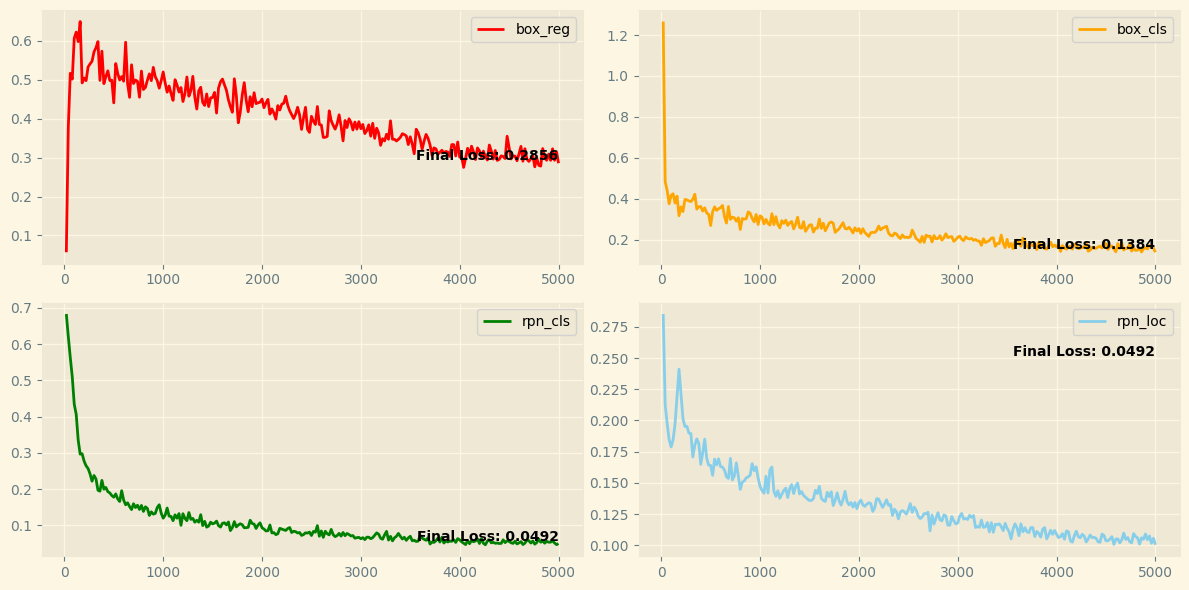

In [24]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
tmp1 = metrics[~metrics['loss_box_reg'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_box_reg'], color='red', label='box_reg')
plt.grid(True); plt.legend()

final_iter = tmp1['iteration'].iloc[-1]
final_loss = tmp1['loss_box_reg'].iloc[-1]

# 그래프에 텍스트 추가
plt.text(final_iter, final_loss, f'Final Loss: {final_loss:.4f}', 
         verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='black', fontweight='bold')

plt.subplot(2,2,2)
tmp2 = metrics[~metrics['loss_cls'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_cls'], color='orange', label='box_cls')
plt.grid(True); plt.legend()

final_iter = tmp2['iteration'].iloc[-1]
final_loss = tmp2['loss_cls'].iloc[-1]

# 그래프에 텍스트 추가
plt.text(final_iter, final_loss, f'Final Loss: {final_loss:.4f}', 
         verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='black', fontweight='bold')

plt.subplot(2,2,3)
tmp3 = metrics[~metrics['loss_rpn_cls'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_rpn_cls'], color='green', label='rpn_cls')
plt.grid(True); plt.legend()

final_iter = tmp3['iteration'].iloc[-1]
final_loss = tmp3['loss_rpn_cls'].iloc[-1]

# 그래프에 텍스트 추가
plt.text(final_iter, final_loss, f'Final Loss: {final_loss:.4f}', 
         verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='black', fontweight='bold')

plt.subplot(2,2,4)
tmp4 = metrics[~metrics['loss_rpn_loc'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_rpn_loc'], color='skyblue', label='rpn_loc')
plt.grid(True); plt.legend()

final_iter = tmp4['iteration'].iloc[-1]
final_loss = tmp4['loss_rpn_cls'].iloc[-1]

# 그래프에 텍스트 추가
plt.text(final_iter, final_loss + 0.2, f'Final Loss: {final_loss:.4f}', 
         verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

### Visualize Valid Metric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.6 MB/s eta 0:00:00


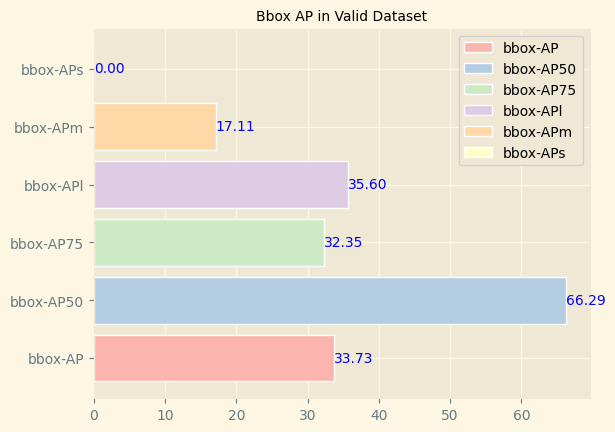

In [25]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

bbox_tmp = metrics[['bbox/AP','bbox/AP50', 'bbox/AP50', 'bbox/APl', 'bbox/APm', 'bbox/APs']]

plt.title('Bbox AP in Valid Dataset', size=10)
ax = plt.barh(y=['bbox-AP', 'bbox-AP50', 'bbox-AP75', 'bbox-APl', 'bbox-APm', 'bbox-APs'],
        width=[metrics.iloc[-1]['bbox/AP'], metrics.iloc[-1]['bbox/AP50'], metrics.iloc[-1]['bbox/AP75'], metrics.iloc[-1]['bbox/APl'],
           metrics.iloc[-1]['bbox/APm'], metrics.iloc[-1]['bbox/APs'],], 
        color=pbq.Pastel1_7.hex_colors, edgecolor='white',
        label=['bbox-AP', 'bbox-AP50', 'bbox-AP75', 'bbox-APl', 'bbox-APm', 'bbox-APs'])

for rect in ax.patches:
    x = rect.get_width()
    y = rect.get_y() + rect.get_height()/2.0
    plt.text(x, y, f'{x:.2f}', ha='left', va='center', size=10, color='blue')

plt.legend()
plt.show()

- #### AP by class

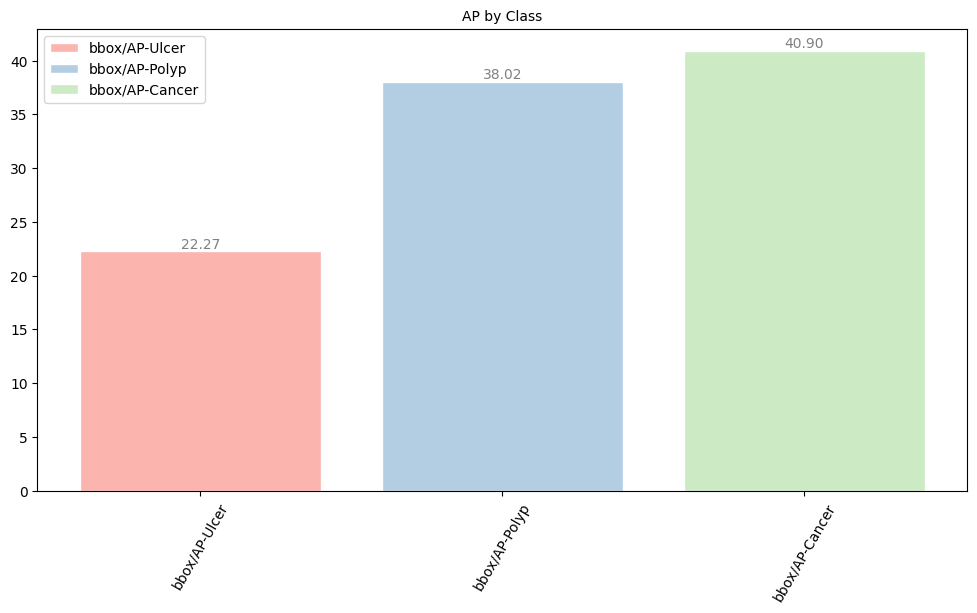

In [26]:
plt.style.use('default')
plt.figure(figsize=(12,6))

bbox_tmp = metrics[[f'bbox/AP-{col}' for col in thing_classes]]

plt.title('AP by Class', size=10)
ax = plt.bar(
    x=[f'bbox/AP-{col}' for col in thing_classes],
    height=[metrics.iloc[-1][f'bbox/AP-{col}'] for col in thing_classes],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=[f'bbox/AP-{col}' for col in thing_classes]
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()